<a href="https://colab.research.google.com/github/gaegoori/handsignproject/blob/model/%EA%B8%B0%ED%95%99%EA%B8%B0%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%AA%A8%EB%8D%B8(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Drive 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%%bash
SRC="/content/drive/MyDrive/keypoints_all"
DST="/content/drive/MyDrive/keypoints_160F"

mkdir -p "$DST"

echo "정확한 WORD0001~0160 + REAL01~16 + F 버전만 추출 시작"

for z in "$SRC"/*.zip; do
    echo "ZIP 처리 중: $z"

    # 정확한 숫자 범위만 포함 (0001~0160)
    for i in $(seq -f "%04g" 1 160); do
        unzip -qq "$z" "*/NIA_SL_WORD${i}_REAL*_F*" -d "$DST"
    done
done

echo "추출 완료"
echo "저장 위치: $DST"

In [ ]:
import os
from zipfile import ZipFile

zip_path = "/content/drive/MyDrive/01_real_word_morpheme.zip"   # 업로드한 경로
extract_to = "/content/drive/MyDrive/morpheme_full"

os.makedirs(extract_to, exist_ok=True)

with ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print("압축해제 완료:", extract_to)

압축해제 완료: /content/drive/MyDrive/morpheme_full


In [ ]:
import os, json, glob
from tqdm import tqdm

# 0. 경로 설정
# Keypoint 폴더 루트 경로
keypoint_root = "/content/drive/MyDrive/keypoints_160F"
# Morpheme 파일 루트 경로
morpheme_root = "/content/drive/MyDrive/morpheme_full/morpheme"
# 최종 JSON 파일 저장될 경로
output_dir = "/content/drive/MyDrive/sign_data/fast_index"

os.makedirs(output_dir, exist_ok=True)

# 1. WORD 0001 ~ 0160 자동 생성
selected_words = {f"NIA_SL_WORD{str(i).zfill(4)}" for i in range(1, 161)}
print(f"선택된 단어 수: {len(selected_words)}개 (160개면 정상)")


# 2. morpheme 파일 로드 및 REAL ID 딕셔너리 생성
morpheme_files = glob.glob(os.path.join(morpheme_root, "**/*.json"), recursive=True)
morpheme_dict = {}

def extract_real_id_from_morpheme(filename):
    # NIA_SL_WORD0001_REAL02_morpheme.json → NIA_SL_WORD0001_REAL02 추출
    name = os.path.basename(filename).replace("_morpheme.json", "")
    return name.rsplit("_", 1)[0]

for f in tqdm(morpheme_files, desc="Morpheme 파일 로드"):
    real_id = extract_real_id_from_morpheme(f)
    base_word = real_id.split("_REAL")[0] # NIA_SL_WORD0001

    # 선택된 단어에 포함되는 경우에만 딕셔너리에 추가
    if base_word in selected_words:
        # REAL ID를 고유 키로 사용하여 1:1 매칭 준비
        morpheme_dict[real_id] = f

print(f"필터링된 morpheme (REAL ID 기준) 개수: {len(morpheme_dict)}개")


# 3. keypoint 폴더 로드 (F 버전만)
keypoint_dirs = []

for root, dirs, files in os.walk(keypoint_root):
    for d in dirs:
        # 예: NIA_SL_WORD0001_REAL03_F 형식의 폴더만 선택
        if d.startswith("NIA_SL_WORD") and "_REAL" in d and d.endswith("_F"):
            keypoint_dirs.append(os.path.join(root, d))

print(f"선택된 keypoint 폴더 수: {len(keypoint_dirs)}개")


def extract_real_id_from_kp(folder_name):
    # NIA_SL_WORD0001_REAL03_F → NIA_SL_WORD0001_REAL03 추출
    return folder_name.rsplit("_", 1)[0]


# 4. keypoint ↔ morpheme 1:1 매칭 및 fast_index 생성
fast_index = []

for kp_path in tqdm(keypoint_dirs, desc="단어 매칭 중"):
    folder_name = os.path.basename(kp_path)

    # 1:1 매칭을 위한 REAL ID 추출
    real_id = extract_real_id_from_kp(folder_name)

    # base_word 추출 (선택된 단어 확인용)
    base_word = real_id.split("_REAL")[0]

    # base_word가 선택 목록에 있고, 해당 REAL ID의 morpheme 파일이 morpheme_dict에 있는 경우 매칭
    if base_word in selected_words and real_id in morpheme_dict:
        morpheme_path = morpheme_dict[real_id]

        fast_index.append({
            "word_id": base_word,
            "real_id": real_id, # 매칭된 고유 ID
            "keypoint_path": kp_path,
            "morpheme_path": morpheme_path
        })

print(f"최종 매칭된 데이터 개수: {len(fast_index)}개")


# 5. JSON 저장
output_path = os.path.join(output_dir, "fast_match.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(fast_index, f, indent=4, ensure_ascii=False)

print("\n 저장 완료:", output_path)

선택된 단어 수: 160개 (160개면 정상)


Morpheme 파일 로드: 100%|██████████| 159672/159672 [00:00<00:00, 353926.36it/s]


필터링된 morpheme (REAL ID 기준) 개수: 1760개
선택된 keypoint 폴더 수: 2560개


단어 매칭 중: 100%|██████████| 2560/2560 [00:00<00:00, 105017.59it/s]

최종 매칭된 데이터 개수: 1760개

 저장 완료: /content/drive/MyDrive/sign_data/fast_index/fast_match.json


In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
import os, json, ujson, numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# 0. 경로 설정
# 입력 파일: 이전 단계에서 생성된 1:1 매칭 인덱스 파일
fast_index_path = "/content/drive/MyDrive/sign_data/fast_index/fast_match.json"
# 출력 파일: Keypoint와 형태소 정보를 결합한 최종 데이터셋
output_path = "/content/drive/MyDrive/sign_data/processed/merged_dataset.json"

os.makedirs(os.path.dirname(output_path), exist_ok=True)

# 매칭 인덱스 로드
try:
    with open(fast_index_path, "r", encoding="utf-8") as f:
        pairs = json.load(f)
except FileNotFoundError:
    print(f"오류: fast_index 파일이 경로에 없습니다. 경로를 확인해주세요: {fast_index_path}")
    pairs = []
except Exception as e:
    print(f"오류: fast_index 파일 로드 중 예외 발생: {e}")
    pairs = []

print(f"처리할 매칭 쌍 개수: {len(pairs)}개")


# 1. Keypoint 데이터 로드 및 정제 함수
def load_person_data(fp):
    """프레임 하나 빠르게 읽고 (N, 3) Keypoint 배열 반환"""
    try:
        # ujson으로 파일 빠르게 로드
        with open(fp, "r") as f:
            kf = ujson.load(f)
    except:
        return None

    # 'people' 데이터 추출 및 형식 통일
    people = kf.get("people", [])
    if isinstance(people, dict):
        people = [people.get("0", people)]

    if not people:
        return None

    person = people[0]

    def safe_array(key):
        """키포인트를 안전하게 로드하고 (N, 3) 형태로 변환"""
        arr = person.get(key, [])
        if not arr:
            # 데이터가 없는 경우 (0, 3) 배열 반환
            return np.zeros((0, 3), dtype=np.float32)

        arr = np.array(arr, dtype=np.float32)
        # 2D 키포인트는 (N*3,) 형태이므로 (N, 3)으로 재구성
        return arr.reshape(-1, 3)

    # Keypoint 추출 및 연결 순서: Pose(25) + LeftHand(21) + RightHand(21) + Face(70) = 137 Keypoints
    p = safe_array("pose_keypoints_2d")
    lh = safe_array("hand_left_keypoints_2d")
    rh = safe_array("hand_right_keypoints_2d")
    face = safe_array("face_keypoints_2d")

    # 모든 키포인트 연결
    full = np.concatenate([p, lh, rh, face], axis=0)

    # 신뢰도(Confidence, 3번째 열)가 0.5 미만인 키포인트는 0으로 설정
    full[full[:, 2] < 0.5] = 0

    return full


# 2. 병렬 처리 함수
def process_item(item):
    """단어 1개의 Keypoint와 Morpheme을 결합하여 프레임 시퀀스 생성"""
    keypoint_dir = item["keypoint_path"]
    morpheme_path = item["morpheme_path"]
    fps = 30 # 초당 프레임 수 (NIA 수어 데이터셋 표준)
    real_id = item.get("real_id", "N/A") # real_id 가져오기

    # Morpheme 로드
    try:
        with open(morpheme_path, "r", encoding="utf-8") as f:
            mor = ujson.load(f)
        segments = mor.get("data", [])
        if not isinstance(segments, list):
             segments = [segments]
    except Exception:
        # print(f"Morpheme 로드 오류: {morpheme_path}")
        return []

    # Keypoint 프레임 파일 목록
    frame_files = sorted([
        os.path.join(keypoint_dir, f)
        for f in os.listdir(keypoint_dir)
        if f.endswith(".json")
    ])

    if not frame_files:
        return []

    # 모든 프레임 데이터 로드
    frames = []
    for fp in frame_files:
        full = load_person_data(fp)
        # 키포인트 개수 확인 (137개 = 25+21+21+70)
        if full is not None and full.shape[0] == 137:
            frames.append(full)

    if not frames:
        return []

    frames = np.stack(frames).astype(np.float32)
    results = []

    # 형태소 구간별 잘라서 저장
    for seg in segments:
        try:
            start_idx = int(seg["start"] * fps)
            end_idx = int(seg["end"] * fps)

            # 유효성 검사
            if start_idx >= len(frames) or end_idx <= start_idx:
                continue

            # 프레임 자르기
            cut = frames[start_idx:min(end_idx, len(frames))]

            results.append({
                "word_id": item["word_id"],
                "real_id": real_id,
                "label": seg["attributes"], # 형태소 레이블
                "frames": cut.tolist() # 넘파이 배열을 리스트로 변환
            })
        except Exception:
             # print(f"세그먼트 처리 오류: {real_id} - {seg}")
             continue

    return results


# 3. 단어 전체를 병렬 처리 및 데이터 병합
merged_data = []
if pairs:
    # CPU 코어 수만큼 Pool 생성
    core_count = cpu_count()
    print(f"사용 가능한 CPU 코어 수: {core_count}")
    with Pool(core_count) as P:
        # imap_unordered를 사용하여 결과를 비동기적으로 가져옴
        for res in tqdm(P.imap_unordered(process_item, pairs), total=len(pairs), desc="데이터 결합 중"):
            merged_data.extend(res)


# 4. JSON 저장 (ujson 사용)
if merged_data:
    try:
        print("\n데이터를 JSON 파일로 저장 중...")
        with open(output_path, "w") as f:
            ujson.dump(merged_data, f)

        print("\n 완료")
        print(f"최종 저장된 형태소 세그먼트 개수: {len(merged_data)}개")
        print(f"경로: {output_path}")
    except Exception as e:
        print(f"저장 오류: {e}")
else:
    print("\n 처리된 데이터가 없어 저장하지 않습니다.")

처리할 매칭 쌍 개수: 1760개
사용 가능한 CPU 코어 수: 2


데이터 결합 중: 100%|██████████| 1760/1760 [10:22:26<00:00, 21.22s/it]



데이터를 JSON 파일로 저장 중...

✅ 완료
최종 저장된 형태소 세그먼트 개수: 1757개
경로: /content/drive/MyDrive/sign_data/processed/merged_dataset.json


In [2]:
import numpy as np
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 파일 로드
file_path = '/content/drive/MyDrive/sign_data/processed/merged_dataset.json'

print("데이터 로드...")
with open(file_path, 'r') as f:
    data_json = json.load(f)
print("로드 완료. 총 세그먼트 수:", len(data_json))


# 2. frames padding → raw_data 생성
keypoint_data_list = [item["frames"] for item in data_json]

print("padding 중...")
padded_data = pad_sequences(keypoint_data_list, padding='post', dtype='float32')
raw_data = np.array(padded_data)
print("raw_data shape:", raw_data.shape)   # (N, T, 137, 3)


# 3. 4D → (N,T,F) reshape
N, T, P, C = raw_data.shape
F = P * C
raw_flat = raw_data.reshape(N, T, F)
print("reshape 완료:", raw_flat.shape)


# 4. Mid-Hip 상대좌표 (x,y만 변환)
def apply_midhip_relative(raw):
    print("Mid-Hip 상대좌표 변환 중...")

    N, T, F = raw.shape
    num_points = F // 3

    arr = raw.reshape(N, T, num_points, 3)

    REF = 0  # Mid-Hip index
    ref_xy = arr[:, :, REF, :2]
    ref_xy = ref_xy[:, :, None, :]

    arr[:, :, :, :2] -= ref_xy  # x,y만 상대좌표

    return arr.reshape(N, T, F)

X_midhip = apply_midhip_relative(raw_flat)
print("Mid-Hip 완료:", X_midhip.shape)


# 5. 핵심 keypoint 선택 (18개 → 54차원)
POSE_IDXS = [0,1,2,3,4,5,6,7]
HAND_IDXS = [4,8,12,16,20]

def select_keypoints(frame_137x3):
    pose = frame_137x3[:25]
    lh   = frame_137x3[25:46]
    rh   = frame_137x3[46:67]

    selected = []
    for idx in POSE_IDXS: selected.append(pose[idx])
    for idx in HAND_IDXS: selected.append(lh[idx])
    for idx in HAND_IDXS: selected.append(rh[idx])

    return np.array(selected).reshape(-1)

def apply_keypoint_selection(X):
    print("핵심 keypoint 선택 중...")
    N,T,F = X.shape
    num_points = F//3
    Xr = X.reshape(N,T,num_points,3)

    X_new = np.zeros((N,T,54), dtype=np.float32)

    for i in range(N):
        for t in range(T):
            X_new[i,t] = select_keypoints(Xr[i,t])

    print("완료:", X_new.shape)
    return X_new

X_selected = apply_keypoint_selection(X_midhip)


# 강화된 interpolation
def interpolate_strong(frames, th=0.5):
    """
    v1 → prev/next 기반 보간
    v2 → forward fill + backward fill + segment linear interpolation 추가
    """
    T,F = frames.shape
    P = F//3
    arr = frames.reshape(T, P, 3)

    for p in range(P):  # 각 keypoint마다 처리
        conf = arr[:, p, 2]
        x = arr[:, p, 0]
        y = arr[:, p, 1]

        # forward fill (뒤에서 가져와 채우기)
        for t in range(1, T):
            if conf[t] < th and conf[t-1] >= th:
                x[t] = x[t-1]
                y[t] = y[t-1]
                conf[t] = conf[t-1]

        # backward fill (앞에서 가져와 채우기)
        for t in range(T-2, -1, -1):
            if conf[t] < th and conf[t+1] >= th:
                x[t] = x[t+1]
                y[t] = y[t+1]
                conf[t] = conf[t+1]

        # segment-based interpolation
        low_idx = np.where(conf < th)[0]

        if len(low_idx) > 0:
            # 연속 구간 탐색
            seg_starts = []
            seg_ends = []

            start = low_idx[0]
            prev = low_idx[0]

            for idx in low_idx[1:]:
                if idx != prev + 1:
                    seg_starts.append(start)
                    seg_ends.append(prev)
                    start = idx
                prev = idx
            seg_starts.append(start)
            seg_ends.append(prev)

            # 각 연속 구간 보간
            for s, e in zip(seg_starts, seg_ends):
                prev_t = s - 1
                next_t = e + 1

                if prev_t < 0 or next_t >= T:
                    continue

                # 선형 보간
                for t in range(s, e+1):
                    ratio = (t - s + 1) / (e - s + 2)
                    x[t] = (1-ratio) * x[prev_t] + ratio * x[next_t]
                    y[t] = (1-ratio) * y[prev_t] + ratio * y[next_t]
                    conf[t] = max(conf[prev_t], conf[next_t])

        arr[:, p, 0] = x
        arr[:, p, 1] = y
        arr[:, p, 2] = conf

    return arr.reshape(T, F)


print("강화된 interpolation v2 적용 중...")
X_interp = np.zeros_like(X_selected)
for i in range(len(X_selected)):
    X_interp[i] = interpolate_strong(X_selected[i])
print("보간 완료:", X_interp.shape)


# confidence 제거 (x,y만)
def remove_confidence(X):
    N,T,F = X.shape
    P = F//3
    coords = X.reshape(N,T,P,3)[:,:,:,:2]
    return coords.reshape(N,T,P*2)

X_xy = remove_confidence(X_interp)
print("confidence 제거 완료:", X_xy.shape)


# 단순 스케일링
X_xy /= 1000.0


# Train/Test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

labels_text = np.array([item["label"][0]["name"] for item in data_json])
encoder = LabelEncoder()
y = encoder.fit_transform(labels_text)

X_train, X_test, y_train, y_test = train_test_split(
    X_xy, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

print("전처리 파이프라인 완료 v")


데이터 로드...
로드 완료. 총 세그먼트 수: 1757
padding 중...
raw_data shape: (1757, 106, 137, 3)
reshape 완료: (1757, 106, 411)
Mid-Hip 상대좌표 변환 중...
Mid-Hip 완료: (1757, 106, 411)
핵심 keypoint 선택 중...
완료: (1757, 106, 54)
강화된 interpolation v2 적용 중...
보간 완료: (1757, 106, 54)
confidence 제거 완료: (1757, 106, 36)
Train: (1405, 106, 36)
Test : (352, 106, 36)
전처리 파이프라인 완료 v


Environment reset complete.
원본 샘플 수: 1757
구조 이상 샘플 수: 0
원본 클래스 개수: 160
라벨 정제 완료!
정제 후 샘플 수: 1756
제거된 라벨: ['결승전1']
정제 후 클래스 개수: 159
상위 10개: [('음주운전', 22), ('백설기', 12), ('체감', 12), ('고민', 11), ('수어', 11), ('뻔뻔', 11), ('눈', 11), ('발가락', 11), ('슬프다', 11), ('독신', 11)]
샘플수 2 미만 여부: []
최소 길이: 15
최대 길이: 106
평균 길이: 54.87072892938497


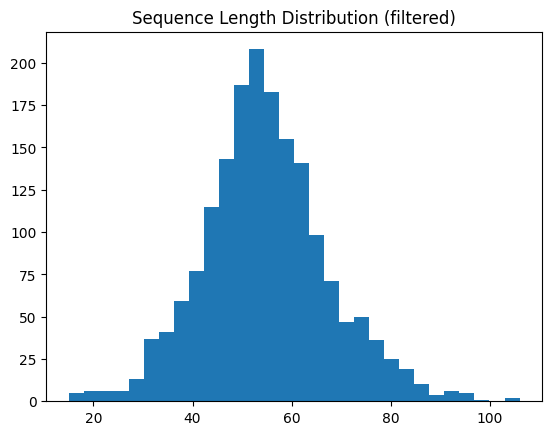

Padding 완료: (1756, 106, 137, 3)
X_raw shape: (1756, 106, 137, 3)
Mid-Hip Normalize 완료: (1756, 106, 137, 3)
Full Skeleton XY Features: (1756, 106, 134)
클래스 수: 159
Train Raw: (1404, 106, 134)
Test  Raw: (352, 106, 134)
mean shape: (134,) std shape: (134,)
Normalization 완료.
Train: (1404, 106, 134)
Test : (352, 106, 134)
원본 Train: (1404, 106, 134) 1404
증강 포함 Train: (2808, 106, 134) 2808

 Class Weights: {0: np.float64(0.9811320754716981), 1: np.float64(1.1037735849056605), 2: np.float64(1.1037735849056605), 3: np.float64(0.9811320754716981), 4: np.float64(0.9811320754716981), 5: np.float64(0.9811320754716981), 6: np.float64(0.9811320754716981), 7: np.float64(1.1037735849056605), 8: np.float64(1.1037735849056605), 9: np.float64(0.9811320754716981), 10: np.float64(0.9811320754716981), 11: np.float64(0.9811320754716981), 12: np.float64(0.9811320754716981), 13: np.float64(0.9811320754716981), 14: np.float64(0.9811320754716981), 15: np.float64(0.9811320754716981), 16: np.float64(1.1037735849056

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 134) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None, 134) │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, None, 134) │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, None)      │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     76,416 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 128) │     66,048 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 128) │          0 │ bidirectional[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 128) │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 128) │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 128) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 128) │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 32)        │     15,456 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 159)       │     10,335 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 187,391 (732.00 KB)

 Trainable params: 187,391 (732.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 59s 435ms/step - accuracy: 0.0071 - loss: 5.1165 - val_accuracy: 0.0107 - val_loss: 5.0090 - learning_rate: 3.0000e-04
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0136 - loss: 5.0256 - val_accuracy: 0.0338 - val_loss: 4.9316 - learning_rate: 3.0000e-04
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0230 - loss: 4.9448 - val_accuracy: 0.0338 - val_loss: 4.8528 - learning_rate: 3.0000e-04
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.0292 - loss: 4.8449 - val_accuracy: 0.0463 - val_loss: 4.7404 - learning_rate: 3.0000e-04
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0418 - loss: 4.7689 - val_accuracy: 0.0605 - val_loss: 4.6374 - learning_rate: 3.0000e-04
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0358 - loss: 4.6889 - val_accuracy: 0.0658 - val_loss: 4.5220 - learning_rate: 3.0000e-04
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy

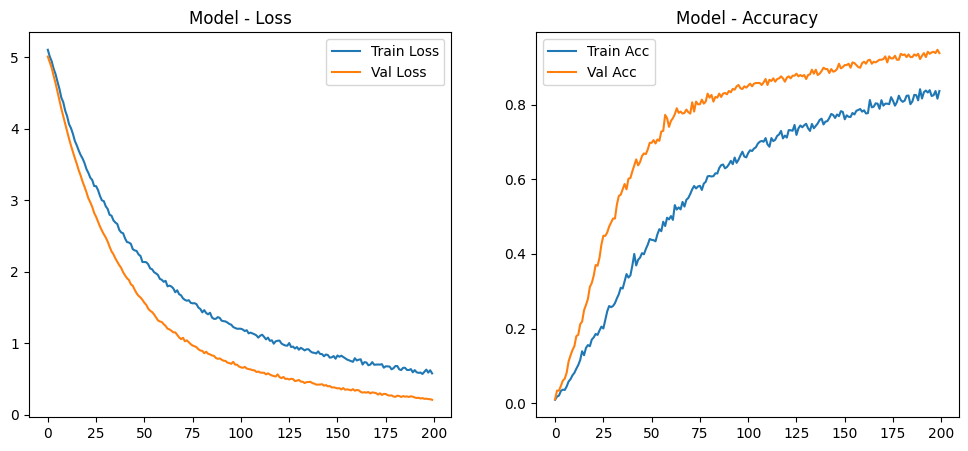


 Best Epoch: 200
 Final Train Accuracy: 0.8362
 Best Validation Accuracy: 0.9377
 Final Train Loss: 0.5786
 Best Validation Loss: 0.2097

 Test Loss: 1.6324,  Test Accuracy: 0.7841


In [3]:
# 환경 초기화 & 기본 설정
import gc
import random
import numpy as np
import json
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Masking, Bidirectional, GRU,
    Dense, Dropout, LayerNormalization,
    Attention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 메모리 / 세션 초기화
gc.collect()
tf.keras.backend.clear_session()

# 재현성
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Environment reset complete.")


# 데이터 로드 & 라벨 정제
file_path = '/content/drive/MyDrive/sign_data/processed/merged_dataset.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data_json = json.load(f)

print("원본 샘플 수:", len(data_json))

# 필수 키 체크
required_keys = {"frames", "label"}
issues = [i for i, item in enumerate(data_json) if not required_keys.issubset(item.keys())]
print("구조 이상 샘플 수:", len(issues))

# 라벨 오타 → 표준 라벨 매핑
label_fix_map = {
    "꽈베기": "꽈배기",
    "배추국": "배춧국",
    "된장찌게": "된장찌개",
}

for item in data_json:
    label = item['label'][0]['name']
    if label in label_fix_map:
        item['label'][0]['name'] = label_fix_map[label]

# 라벨 분포 확인
labels_all = [item['label'][0]['name'] for item in data_json]
label_counts_all = Counter(labels_all)
print("원본 클래스 개수:", len(label_counts_all))

# 샘플 2개 미만 라벨 제거
remove_labels = [k for k, v in label_counts_all.items() if v < 2]
filtered_data = [item for item in data_json if item['label'][0]['name'] not in remove_labels]

print("라벨 정제 완료!")
print("정제 후 샘플 수:", len(filtered_data))
print("제거된 라벨:", remove_labels)

# 정제 후 라벨 분포
labels_filtered = [item['label'][0]['name'] for item in filtered_data]
label_counts_filtered = Counter(labels_filtered)
print("정제 후 클래스 개수:", len(label_counts_filtered))
print("상위 10개:", label_counts_filtered.most_common(10))
print("샘플수 2 미만 여부:", [k for k,v in label_counts_filtered.items() if v < 2])

# 각 샘플 길이
seq_lengths_all = np.array([len(item['frames']) for item in filtered_data])
print("최소 길이:", seq_lengths_all.min())
print("최대 길이:", seq_lengths_all.max())
print("평균 길이:", seq_lengths_all.mean())

plt.hist(seq_lengths_all, bins=30)
plt.title("Sequence Length Distribution (filtered)")
plt.show()


# frames padding → (N, T, 137, 3)
def pad_frames(dataset):
    sequences = [item["frames"] for item in dataset]
    padded = pad_sequences(sequences, padding='post', dtype='float32')
    print("Padding 완료:", padded.shape)
    return padded

X_raw = pad_frames(filtered_data)   # (N, T, 137, 3)
N, T_max, P, C = X_raw.shape
print("X_raw shape:", X_raw.shape)


# Mid-Hip 기준 상대 좌표 변환

def normalize_midhip(X):

    X = X.copy()
    N, T, P, C = X.shape

    REF_INDEX = 0  # Mid-Hip
    ref_xy = X[:, :, REF_INDEX, :2]         # (N,T,2)
    ref_xy = ref_xy[:, :, None, :]          # (N,T,1,2)

    X[:, :, :, :2] -= ref_xy                # x,y → 상대좌표

    print("Mid-Hip Normalize 완료:", X.shape)
    return X

X_norm_mhip = normalize_midhip(X_raw)


# 포즈 + 양손 스켈레톤 XY만 추출 → (N, T, D)
# (몸 25 + 왼손 21 + 오른손 21 = 67 포인트)
def extract_xy_features(X):

    N, T, P, C = X.shape

    pose = X[:, :, :25, :]      # body
    lh   = X[:, :, 25:46, :]    # left hand
    rh   = X[:, :, 46:67, :]    # right hand

    full = np.concatenate([pose, lh, rh], axis=2)  # (N,T,67,3)

    xy = full[:, :, :, :2]      # x,y만
    final = xy.reshape(N, T, -1)

    print("Full Skeleton XY Features:", final.shape)
    return final

X_xy_all = extract_xy_features(X_norm_mhip)   # (N, T, 134)


# 라벨 인코딩 & Train/Test Split (stratify)
encoder = LabelEncoder()
y_all = encoder.fit_transform(labels_filtered)
num_classes = len(np.unique(y_all))
print("클래스 수:", num_classes)

idx_all = np.arange(len(y_all))
idx_train, idx_test = train_test_split(
    idx_all,
    test_size=0.2,
    shuffle=True,
    stratify=y_all,
    random_state=42
)

X_train_raw = X_xy_all[idx_train]
X_test_raw  = X_xy_all[idx_test]
y_train = y_all[idx_train]
y_test  = y_all[idx_test]
seq_train = seq_lengths_all[idx_train]
seq_test  = seq_lengths_all[idx_test]

print("Train Raw:", X_train_raw.shape)
print("Test  Raw:", X_test_raw.shape)


# Z-Score 정규화 (Train 유효 프레임 기준)
# → 패딩(길이 이후)은 그대로 0 유지
def compute_mean_std_nonpad(X, seq_lengths):
    """
    X : (N,T,D), seq_lengths : (N,)
    유효 프레임(t < seq_len)에 대해서만 mean, std 계산
    """
    N, T, D = X.shape
    total_frames = int(seq_lengths.sum())

    s = np.zeros(D, dtype=np.float64)
    ss = np.zeros(D, dtype=np.float64)

    for i in range(N):
        L = seq_lengths[i]
        if L == 0:
            continue
        Xi = X[i, :L, :]       # (L,D)
        s  += Xi.sum(axis=0)
        ss += (Xi ** 2).sum(axis=0)

    mean = s / total_frames
    var  = ss / total_frames - mean**2
    std  = np.sqrt(var + 1e-6)

    return mean.astype(np.float32), std.astype(np.float32)

mean_vec, std_vec = compute_mean_std_nonpad(X_train_raw, seq_train)
print("mean shape:", mean_vec.shape, "std shape:", std_vec.shape)

def apply_norm_nonpad(X, seq_lengths, mean, std):

    Xn = np.zeros_like(X, dtype=np.float32)
    N, T, D = X.shape

    for i in range(N):
        L = seq_lengths[i]
        if L == 0:
            continue
        Xi = X[i, :L, :]
        Xn[i, :L, :] = (Xi - mean) / std
        # 나머지 [L:]는 0 (패딩)

    return Xn

X_train = apply_norm_nonpad(X_train_raw, seq_train, mean_vec, std_vec)
X_test  = apply_norm_nonpad(X_test_raw,  seq_test,  mean_vec, std_vec)

print("Normalization 완료.")
print("Train:", X_train.shape)
print("Test :", X_test.shape)


# 데이터 증강 (Train만)
# - Gaussian Noise
# - Frame Dropout
def augment_data_v2(x, seq_len,
                    noise_std=0.01,
                    dropout_rate=0.05,
                    shift_range=0.05,
                    scale_range=0.1):

    T_max, D = x.shape
    L = int(seq_len)

    if L <= 0:
        return x.copy()

    x_out = x.copy()
    x_valid = x_out[:L]

    # 1) Gaussian noise
    x_valid += np.random.normal(0, noise_std, size=x_valid.shape).astype(x_valid.dtype)

    # 2) global shift (전체 좌표 평행이동)
    shift = np.random.uniform(-shift_range, shift_range)
    x_valid += shift

    # 3) global scale (몸 크기/카메라 거리 변화)
    scale = 1.0 + np.random.uniform(-scale_range, scale_range)
    x_valid *= scale

    # 4) frame dropout (완전 0이 아니라 약하게 줄이기)
    drop_mask = np.random.rand(L) < dropout_rate
    if drop_mask.any():
        x_valid[drop_mask] *= 0.1  # 에너지만 줄이고 0은 피함

    x_out[:L] = x_valid
    # [L:] 구간은 원래부터 0 패딩 → 그대로 둠
    return x_out

X_aug_list = []
y_aug_list = []

for i in range(len(X_train)):
    X_aug_list.append(augment_data_v2(X_train[i], seq_train[i]))
    y_aug_list.append(y_train[i])

X_augmented = np.stack(X_aug_list)
y_augmented = np.array(y_aug_list)

X_train2 = np.concatenate([X_train, X_augmented], axis=0)
y_train2 = np.concatenate([y_train, y_augmented], axis=0)

print("원본 Train:", X_train.shape, len(y_train))
print("증강 포함 Train:", X_train2.shape, len(y_train2))

from tensorflow.keras.layers import MultiHeadAttention

def build_hybrid_model(input_dim, num_classes):
    inputs = Input(shape=(None, input_dim))

    # 0) Masking (오른쪽 패딩 0만 마스크)
    x = Masking(mask_value=0.0)(inputs)

    # 1) BiGRU로 1차 시퀀스 인코딩
    x = Bidirectional(
        GRU(
            64,
            return_sequences=True,
            dropout=0.2,
            reset_after=False,
            use_cudnn=False
        )
    )(x)

    # 2) Transformer Encoder 블록 1개
    # - Multi-Head Self-Attention
    attn_out = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization()(x + attn_out)

    # - Position-wise Feed Forward
    ff = Dense(128, activation='relu')(x)
    ff = Dropout(0.3)(ff)
    x = LayerNormalization()(x + ff)

    # 3) GRU로 요약
    x = GRU(
        32,
        dropout=0.3,
        reset_after=False,
        use_cudnn=False
    )(x)

    # 4) Dense head
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Class Weight 적용 (불균형 데이터 대응)
from sklearn.utils.class_weight import compute_class_weight

# class weight 재계산 (증강 포함 y_train2 기준)
class_weights = compute_class_weight(
    "balanced",
    classes=np.unique(y_train2),
    y=y_train2
)
class_weights = dict(enumerate(class_weights))
print("\n Class Weights:", class_weights)


# 학습
model = build_hybrid_model(X_train2.shape[-1], num_classes)
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)
]

history = model.fit(
    X_train2, y_train2,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

def plot_history(history, title="Model"):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.show()


def print_results(history):
    best_epoch = int(np.argmin(history.history['val_loss']) + 1)
    print(f"\n Best Epoch: {best_epoch}")
    print(f" Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f" Best Validation Accuracy: {history.history['val_accuracy'][best_epoch-1]:.4f}")
    print(f" Final Train Loss: {history.history['loss'][-1]:.4f}")
    print(f" Best Validation Loss: {history.history['val_loss'][best_epoch-1]:.4f}")


# 결과 출력
plot_history(history)
print_results(history)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test Loss: {test_loss:.4f},  Test Accuracy: {test_acc:.4f}")